In [ ]:
import numpy as np
import pandas as pd

import os
import matplotlib.pyplot as plt
import pandas_datareader as web
import datetime as dt

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [ ]:
prices = pd.read_csv('prices.csv', header =0)
prices.head()

,date,symbol,open,close,low,high,volume
0,2016-01-05 00:00:00,WLTW,123.430000,125.839996,122.309998,126.250000,2163600.0
1,2016-01-06 00:00:00,WLTW,125.239998,119.980003,119.940002,125.540001,2386400.0
2,2016-01-07 00:00:00,WLTW,116.379997,114.949997,114.930000,119.739998,2489500.0
3,2016-01-08 00:00:00,WLTW,115.480003,116.620003,113.500000,117.440002,2006300.0
4,2016-01-11 00:00:00,WLTW,117.010002,114.970001,114.089996,117.330002,1408600.0


Data Preparation

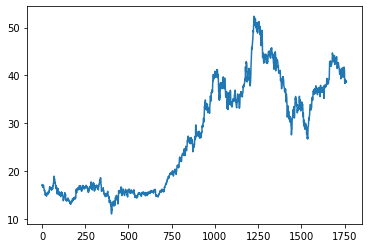

In [ ]:
yahoo = prices[prices['symbol']=='YHOO']
yahoo_prices = yahoo.close.values.astype('float32')
yahoo_prices = yahoo_prices.reshape(1762, 1)
yahoo_prices.shape
plt.plot(yahoo_prices)
plt.show()

Normalize and split the data into train and test

In [ ]:

scaler = MinMaxScaler(feature_range=(0, 1))
yahoo_prices = scaler.fit_transform(yahoo_prices)

train_size = int(len(yahoo_prices) * 0.80)
test_size = len(yahoo_prices) - train_size
train, test = yahoo_prices[0:train_size,:], yahoo_prices[train_size:len(yahoo_prices),:]
print(len(train), len(test))

1409 353


In [ ]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

In [ ]:
# reshape into X=t and Y=t+1
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

Model Building

In [ ]:
#Step 2 Build Model
model = Sequential()

model.add(LSTM(4,
    input_shape=(1, look_back)))
model.add(Dense(1))

model.compile(loss='mse', optimizer='adam')
model.fit(
    trainX,
    trainY,
    batch_size=1,
    epochs=5,
    validation_split=0.05)


Epoch 1/5
1334/1334 [==============================] - 8s 4ms/step - loss: 0.0153 - val_loss: 6.3624e-04
Epoch 2/5
1334/1334 [==============================] - 4s 3ms/step - loss: 3.2277e-04 - val_loss: 8.0133e-04
Epoch 3/5
1334/1334 [==============================] - 4s 3ms/step - loss: 3.2476e-04 - val_loss: 9.9015e-04
Epoch 4/5
1334/1334 [==============================] - 4s 3ms/step - loss: 3.1509e-04 - val_loss: 5.2357e-04
Epoch 5/5
1334/1334 [==============================] - 4s 3ms/step - loss: 3.1311e-04 - val_loss: 6.3708e-04


Model Evalution

In [ ]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# invert the predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

11/11 [==============================] - 0s 3ms/step


In [ ]:
# calculate rmse
import math
from sklearn.metrics import mean_squared_error

trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 0.71 RMSE
Test Score: 0.89 RMSE


In [ ]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(yahoo_prices)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+ look_back, :] = trainPredict

# shift train 
testPredictPlot = np.empty_like(yahoo_prices)
testPredictPlot[:, :] = np.nan
testPredictPlot[(len(trainPredict) + (look_back*2))+1:len(yahoo_prices)-1, :] = testPredict

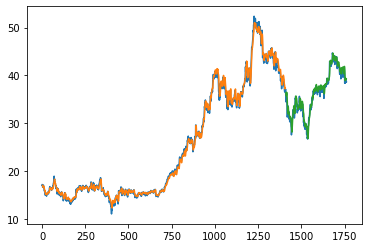

In [ ]:
plt.plot(scaler.inverse_transform(yahoo_prices))
plt.plot(trainPredictPlot, label = 'True')
plt.plot(testPredictPlot, label = 'LSTM')
plt.show()